# Exercise 3
## Jonathan Bollig, Timothy Tempus

# 1 Two moons with an invertible neural network

We will first perform our imports and define some helper functions

In [2]:
# Necessary imports
from itertools import product
from typing import List
import torch
import torch.nn as nn
from sklearn import datasets
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.datasets import load_digits
from argparse import Namespace
import pandas as pd
import os

In [3]:
# Data functions
def get_standardised_moons(n, conditional = False, noise = 0.1, device = 'cpu'):
    x, labels = datasets.make_moons(n_samples = n, noise = noise)

    ## convert data to tensor and standardise
    x = torch.from_numpy(x).float().to(device)
    mean, sd = x.mean(dim=0), x.std(dim=0)
    x_standardised = (x-mean)/sd

    # If conditional, keep labels. Else discard
    if conditional: 
        labels = torch.from_numpy(labels).to(device)
    else:
        labels = None

    return x_standardised, labels

def relabel_to_binary(labels: torch.Tensor, positive_labels: List = [0,2]) -> torch.Tensor:
    """
    Relabel label tensor so 0,2 -> 0 and all else -> 1
    """
    new_labels = torch.zeros_like(labels)

    # Find indices where labels are in positive_labels
    mask = torch.isin(labels, torch.tensor(positive_labels))
    new_labels[mask] = 1
    return new_labels

def get_standardised_gmm(n_samples, radius, conditional = False, device = 'cpu'):
    # Get vertices of regular hexagon centered at origin with radius radius
    thetas = 2*np.pi/6 * np.arange(6)
    vertices = np.stack([
        radius * np.cos(thetas),
        radius * np.sin(thetas)
    ]).T  # Better stacking for 2D points
    
    # Smaller covariance for tighter clusters
    covariance_matrix = np.eye(2) * (radius/10)**2  # Square for proper variance scale
    covs = np.array([covariance_matrix for _ in range(6)])
    precisions = np.linalg.inv(covs)
    
    # Setup GMM
    gmm = GaussianMixture(n_components=6, covariance_type='full')
    gmm.means_ = vertices
    gmm.covariances_ = covs
    gmm.weights_ = np.ones(6)/6
    gmm.precisions_cholesky_ = np.linalg.cholesky(precisions).transpose(0, 2, 1)
    gmm.converged_ = True
    gmm.n_iter_ = 0
    
    # Generate samples
    x, labels = gmm.sample(n_samples)

    ## convert data to tensor and standardise
    x = torch.from_numpy(x).float().to(device)
    mean, sd = x.mean(dim=0), x.std(dim=0)
    x_standardised = (x-mean)/sd

    # If conditional, keep labels. Else discard
    if conditional: 
        labels = torch.from_numpy(labels).to(device)
    else:
        labels = None
    
    return x_standardised, labels

def get_digits(device = 'cpu'):
    # Load dataset
    digits = load_digits()
    x = digits.data
    labels = digits.target

    x = torch.from_numpy(x).float().to(device)
    labels = torch.from_numpy(labels).float().to(device)

    return x, labels

import os
os.chdir('/home/timat/Desktop/UniHeidelberg/GNN')

In [ ]:
# Normalising flow (INN) architecture and helper classes
def get_rand_rotation_mat(n):
    '''
    Obtain random rotation matrix from qr decomposition of a standard normal array
    '''
    a = np.random.randn(n, n)
    q, _ = np.linalg.qr(a)
    return q

class translation_net(nn.Module):
    def __init__(self, in_features, out_features, width, condition_size = 0):
        '''
        in_features: int, number of input features
        width: int, width of the intermediate layers
        Take input of size in_features and output a translation value as follows:
        take input, pass through two fully connected layers with ReLU activation, 
        then pass through another fully connected layer and output a single value
        '''
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.width = width
        self.condition_size = condition_size

        self.fc1 = nn.Linear(in_features + condition_size, width)
        self.fc2 = nn.Linear(width, width)
        self.fc3 = nn.Linear(width, self.out_features)
        self.relu = nn.ReLU()
    def forward(self, x):
        intermediate1 = self.relu(self.fc1(x))
        intermediate2 = self.relu(self.fc2(intermediate1))
        output = self.fc3(intermediate2)
        return output
    
class scaling_net(nn.Module):
    def __init__(self, in_features, out_features, width, condition_size):
        '''
        in_features: int, number of input features
        width: int, width of the intermediate layers
        Same as translation block, but pass output through exp(tanh)
        '''
        super().__init__()
        # Store parameters
        self.in_features = in_features
        self.out_features = out_features
        self.width = width
        self.conditional_size = condition_size

        # Layers
        self.fc1 = nn.Linear(in_features + condition_size, width)
        self.fc2 = nn.Linear(width, width)
        self.fc3 = nn.Linear(width, self.out_features)
        self.relu = nn.ReLU()
    def forward(self, x):
        intermediate1 = self.relu(self.fc1(x))
        intermediate2 = self.relu(self.fc2(intermediate1))
        output_unfixed = self.fc3(intermediate2)
        output = torch.exp(torch.tanh(output_unfixed))
        return output
    
class coupling_layer(nn.Module):
    def __init__(self, data_dim, width, condition_size):
        '''
        Coupling block; as described in lecture
        '''
        super().__init__()
        # Store parameters
        self.data_dim = data_dim
        self.width = width
        self.D_tilde = data_dim // 2 # Number of features to skip
        self.coupling_output_dim = data_dim - self.D_tilde # same as self.D_tilde if data_dim is even

        # Subnetworks
        self.translation = translation_net(self.D_tilde, self.coupling_output_dim, width, condition_size)
        self.scaling = scaling_net(self.D_tilde, self.coupling_output_dim, width, condition_size)

    def forward(self, x, condition = None):
        lower_half = x[:, :self.D_tilde]
        upper_half = x[:, self.D_tilde:]
        
        # Obtain scaling and translation coeffs
        if condition is None:
            # Use lower_half directly without conditions
            trans_coeff = self.translation(lower_half)
            scale_coeff = self.scaling(lower_half)
        else:
            # Add conditions
            lower_half_with_conditions = torch.cat([
                lower_half,
                condition.unsqueeze(1)
            ], dim=1)
            trans_coeff = self.translation(lower_half_with_conditions)
            scale_coeff = self.scaling(lower_half_with_conditions)

        # Skip features up to index D_tilde, apply scaling and translation to the rest element-wise
        output = torch.cat([lower_half, # Skip connection
                            upper_half * scale_coeff + trans_coeff], # Transformed
                            dim = 1) # concatenate for each batch element
        return output
    
    def reverse(self, x, condition):
        lower_half = x[:, :self.D_tilde]
        upper_half = x[:, self.D_tilde:]
        
        # Obtain scaling and translation coeffs
        if condition is None:
            # Use lower_half directly without conditions
            trans_coeff = self.translation(lower_half)
            scale_coeff = self.scaling(lower_half)
        else:
            # Add conditions
            lower_half_with_conditions = torch.cat([
                lower_half,
                condition.unsqueeze(1)
            ], dim=1)
            trans_coeff = self.translation(lower_half_with_conditions)
            scale_coeff = self.scaling(lower_half_with_conditions)

        # Skip features up to index D_tilde, apply scaling and translation to the rest element-wise
        output = torch.cat([lower_half, # Skip connection
                            (upper_half - trans_coeff)/scale_coeff], # Transformed
                            dim = 1) # concatenate for each batch element

        return output

class RealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, blocks, condition_size = 0, device = 'cpu'):
        '''
        input_size: dimension of input data
        hidden_size: width of subnetworks that determine scaling and translation
        blocks: number of coupling layers in the model
        
        Proceed through `blocks` number of coupling layers with subnetworks of width `hidden_size`
        '''
        super().__init__()
        # Store parameters
        self.data_dim = input_size
        self.hidden_size = hidden_size
        self.blocks = blocks

        self.device = device
        self.condition_size = condition_size

        # Create coupling layers
        self.coupling_layers = nn.ModuleList(
            [coupling_layer(self.data_dim, self.hidden_size, condition_size) for _ in range(self.blocks)]
        )

        # Get rotation matrices
        self.rotation_matrices = nn.ParameterList([
            nn.Parameter(
                torch.tensor(
                    get_rand_rotation_mat(self.data_dim),
                    dtype=torch.float32,
                    device=self.device
                ),
                requires_grad=False
            ) for _ in range(self.blocks-1)
        ])


    def forward(self, x, condition = None):
        # Apply coupling layers, interspersing with rotation matrices. Store intermediate output halves
        z = x
        intermediates = []
        for i, coupling_layer in enumerate(self.coupling_layers):
            # Store intermediate half for loss calculation
            intermediates.append(z)

            # pass through coupling layer
            z = coupling_layer(z, condition) 

            if i!= self.blocks-1:
                # apply rotation matrix (except for last layer)
                z = torch.einsum('ij,bj->bi', self.rotation_matrices[i], z)
                
        return intermediates, z

    def reverse(self, z, condition):
        # Apply coupling layers in reverse order, interspersing with inverse rotation matrices
        x_hat = z
        for i, coupling_layer in reversed(list(enumerate(self.coupling_layers))):
            if i!= self.blocks-1:
                # apply inverse rotation matrix (except for first layer)
                x_hat = torch.einsum('ij,bj->bi', 
                                      torch.inverse(self.rotation_matrices[i]), 
                                      x_hat)

            # pass through coupling layer
            if self.condition_size !=0 and condition is None:
                raise ValueError('Model is conditional but no conditions provided')
            x_hat = coupling_layer.reverse(x_hat, condition)

        return x_hat

    # Inference functions
    @torch.no_grad()
    def get_codes(self, x, conditions=None, batch_size=32):
        '''
        Pass a test tensor of data points through the mode
        '''
        outputs = []
        if conditions is None:
            test_loader = DataLoader(x, batch_size = batch_size)


            for x_batch in test_loader:
                x_batch = x_batch.to(self.device)
                _, output = self.forward(x_batch) # Discard intermediates
                outputs.append(output)
        else:
            test_dataset = TensorDataset(x, conditions)
            test_loader = DataLoader(test_dataset, batch_size = batch_size)


            for x_batch, labels_batch in test_loader:
                x_batch = x_batch.to(self.device)
                labels_batch = labels_batch.to(self.device)

                _, output = self.forward(x_batch, labels_batch) # Discard intermediates
                outputs.append(output)

        z = torch.cat(outputs, dim = 0) 

        return z
    
    @torch.no_grad()
    def get_reconstructions(self, z, condition = None, batch_size = 32,):
        if condition is None:
            reverse_loader = DataLoader(z, batch_size = batch_size)

            outputs = []
            for x_batch in reverse_loader:
                x_batch = x_batch.to(self.device)
                output = self.reverse(x_batch, condition)
                outputs.append(output)

        else:
            reverse_dataset = TensorDataset(z, condition)
            reverse_loader = DataLoader(reverse_dataset, batch_size = batch_size)

            outputs = []
            for x_batch, condition_batch in reverse_loader:
                x_batch = x_batch.to(self.device)
                condition_batch = condition_batch.to(self.device)

                output = self.reverse(x_batch, condition_batch)
                outputs.append(output)

        x_reconstructed = torch.cat(outputs, dim = 0)

        return x_reconstructed
    
    def sample(self, n, batch_size = 32, conditions = None, seed = 11121, k = None, fill = 0):
        """
        Sample from data distribution by generating normal samples and passing through
        the model in reverse.
        """
        if seed:
            torch.manual_seed(seed)

        if conditions is None and self.condition_size != 0:
            conditions = range(self.condition_size)

        # If no conditions, just generate sample. Else, generate sample conditioned on conditions
        if conditions is None:
            codes = torch.randn(n,self.data_dim)


            # If k!=0, fill the last k entries with fill
            if k is not None:
                codes[:len(codes)-k] = fill
                
            reconstructions = self.get_reconstructions(codes, batch_size = batch_size)
            labels = None
        else: 
            if not isinstance(conditions, torch.Tensor):
                conditions = torch.tensor(conditions).to(self.device)
            
            # Create n samples for each condition then concatenate
            reconstructions = []
            labels = []
            
            for condition in conditions:
                codes = torch.randn(n,self.data_dim)

                # If k!=0, fill the last k entries with fill
                if k is not None:
                    codes[:len(codes)-k] = fill

                contitional_labels = torch.ones(n)*condition # Each sample has the same condition
                conditional_reconstructions = self.get_reconstructions(codes, contitional_labels, batch_size)
                
                
                reconstructions.append(conditional_reconstructions)
                labels.append(contitional_labels)

            reconstructions = torch.cat(reconstructions, dim = 0)
            labels = torch.cat(labels, dim = 0)


        return reconstructions, labels


In [60]:
# Functions for training
class NLL_and_reconstruction_loss(nn.Module):
    def __init__(self, model: RealNVP, data_dim, k = 0):
        super().__init__()
        self.model = model
        self.coupling_layers = self.model.coupling_layers
        self.data_dim = data_dim
        self.k = k
    
    def forward(self, intermediates, z, condition):
        # Component corresponding to transforming the data
        transformed_component = (z**2).sum(dim=1)/2
        
        # Get log_det_loss component
        log_det_component = 0
        for i in range(len(intermediates)):
            # Get z_{\leq D_tilde}
            lower_half = intermediates[i][:, :self.data_dim//2]
            
            # Get sum of scaling coefficients
            if condition is None:
                # Use lower_half directly without conditions
                scale_coeff = self.coupling_layers[i].scaling(lower_half)
            else:
                # Add conditions
                lower_half_with_conditions = torch.cat([
                    lower_half,
                    condition.unsqueeze(1)
                ], dim=1)
                scale_coeff = self.coupling_layers[i].scaling(lower_half_with_conditions)
            scaling_sum = torch.log(scale_coeff).sum(dim=1)
            log_det_component += scaling_sum

        loss = (transformed_component - log_det_component).mean() # NLL component

        if self.k!=0:
            # Get reconstruction loss
            z_restricted = z.clone()
            z_restricted[:, self.k:] = 0
            x_hat = self.model.reverse(z, condition)
            reconstruction_loss = ((x_hat - z)**2).sum(dim=1).mean()
            loss += reconstruction_loss
        
        return loss
    
def train_epoch(model: RealNVP, train_loader, optimiser, loss_fn: NLL_and_reconstruction_loss, conditional: bool):
    model.train()
    train_loss = 0.

    for x_batch, label_batch in train_loader:
        # Move to gpu if possible
        x_batch, label_batch = x_batch.to(model.device), label_batch.to(model.device)
        
        if not conditional:
            label_batch = None

        # Zero out gradients
        optimiser.zero_grad()

        # Make predictions
        intermediates, z_hat = model(x_batch, label_batch)

        # Get loss, metrics, and gradients
        loss = loss_fn(intermediates, z_hat, label_batch)
        loss.backward()

        # Update
        optimiser.step()

        # Track loss
        train_loss += loss.item()

    # Get loss averaged over batches
    train_loss = train_loss/len(train_loader)


    return train_loss

def get_train_val_split(x_train, labels, batch_size, seed=11121):
    """Split data and corresponding labels into train/val sets"""
    if seed:
        torch.manual_seed(seed)

    if labels is None:
        labels = torch.zeros(x_train.shape[0]) # These will not be used anywhere.

    # Get shuffled indices and apply to both tensors
    shuffled_inds = torch.randperm(x_train.shape[0])
    x_train = x_train[shuffled_inds]
    labels = labels[shuffled_inds]

    # Split 80/20
    cut_index = int(np.floor(0.8 * x_train.shape[0]))
    x_train, x_val = x_train[:cut_index], x_train[cut_index:]
    labels_train, labels_val = labels[:cut_index], labels[cut_index:]

    # Create datasets of pairs
    train_dataset = TensorDataset(x_train, labels_train)
    val_dataset = TensorDataset(x_val, labels_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader

@torch.no_grad()
def get_val_loss(model, val_loader, loss_fn, conditional):
    model.eval()
    val_loss = 0
    for x_batch, label_batch in val_loader:
        # Move to gpu if possible
        x_batch, label_batch = x_batch.to(model.device), label_batch.to(model.device)

        if not conditional:
            label_batch = None

        # Make predictions
        intermediates, x_hat = model(x_batch, label_batch)

        # Get loss
        loss = loss_fn(intermediates, x_hat, label_batch)

        val_loss+=loss.item()

    # Divide to get loss averaged over batches
    val_loss = val_loss/len(val_loader)

    return val_loss

def train_model(model, n_epoch, loss_fn, x_train, labels, conditional, lr, model_path, batch_size = 4, seed = 11121, device = 'cpu'):
    # Get extra necessary objects
    optimiser = torch.optim.Adam(params=model.parameters(), lr=lr)

    # Move to gpu if possible
    x_train = x_train.to(device)

    # Define counter for early stopping to avoid overfitting/computation inefficiency
    early_stop_counter = 0
    early_stop_counter_max = 15 # Stop if no improvement in val loss after this many epochs

    # Make a training/validation split: shuffle and then split
    train_loader, val_loader = get_train_val_split(x_train, labels, batch_size, seed)

    # Train. Terminate early based on validation loss
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}

    for epoch_index in range(n_epoch):

        model.train()
        # Train and get validation loss
        train_loss = train_epoch(model, train_loader, optimiser, loss_fn, conditional)

        val_loss = get_val_loss(model, val_loader, loss_fn, conditional)

        # print outputs
        if epoch_index % 10 == 0:
            print('EPOCH {}:'.format(epoch_index + 1))
            print(f'  training batch loss: {train_loss}')
            print(f'  validation batch loss: {val_loss}')

        # Store losses
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        # If best loss is beat, then keep going. Else increment counter. Stop if counter gets too high
        if val_loss < best_val_loss:
            early_stop_counter = 0 
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch_index,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimiser.state_dict(),
                'loss': best_val_loss,
                'history': history
            }, model_path)

        else:
            early_stop_counter +=1
            if early_stop_counter == early_stop_counter_max:
                print(f'Early stopping after {epoch_index + 1} epochs')
                break

    return history

def init_and_train(hparams, fixed_params, model_path, dataset: str, k:int = 0):
    # Get data
    if dataset == 'moons':
        x_standardised, labels = get_standardised_moons(hparams.n_train, fixed_params.conditional, fixed_params.noise, fixed_params.device)
    elif dataset == 'gmm':
        x_standardised, labels = get_standardised_gmm(hparams.n_train, fixed_params.radius, fixed_params.conditional, fixed_params.device)
        if fixed_params.conditional and fixed_params.positive_labels is not None:
            labels = relabel_to_binary(labels, positive_labels=fixed_params.positive_labels)
    elif dataset == 'digits':
        x_standardised, labels = get_digits() # Not actually standardised, but called so for consistency

    if not fixed_params.conditional:
        labels = None

    # Get model
    if fixed_params.seed is not None:
        torch.manual_seed(fixed_params.seed)

    inn = RealNVP(fixed_params.input_size, 
                  hparams.hidden_size, 
                  hparams.blocks, 
                  fixed_params.condition_size,
                  fixed_params.device).to(fixed_params.device)

    # Train model
    loss_fn = NLL_and_reconstruction_loss(inn, fixed_params.input_size, k)
    history = train_model(inn, hparams.n_epoch, loss_fn, x_standardised, labels, fixed_params.conditional, hparams.lr, model_path=model_path, device = fixed_params.device, batch_size=fixed_params.batch_size)

    return history

def init_and_train_from_grid(hparams_grid, fixed_params, model_path_template, dataset, k:int = 0):
    '''
    Take grid of hyperparams and train models for all combinations
    '''
    # Copy hyperparams
    hparams = Namespace(**vars(hparams_grid))
    results = pd.DataFrame(columns=['hidden_size', 'blocks', 'n_train', 'lr', 'min_val_loss'])
    
    for hidden_size, blocks, n_train, lr in product(hparams_grid.hidden_size, hparams_grid.blocks, hparams_grid.n_train, hparams_grid.lr):
    # Overwrite list with fixed value
        hparams.n_train = n_train
        hparams.hidden_size = hidden_size
        hparams.blocks = blocks
        hparams.lr = lr

        model_path = model_path_template.replace('.pt', 
                                       f'_ntrain{n_train}_hiddensize{hidden_size}_blocks{blocks}_lr{str(lr).replace('.',',')}.pt')
        print(f'Training model {model_path}')

        history = init_and_train(hparams, fixed_params, model_path, dataset, k)

        # Get minimum validation loss
        min_val_loss = min(history['val_loss'])
        
        # Add row to results DataFrame
        results.loc[len(results)] = [int(hidden_size), int(blocks), int(n_train), lr, min_val_loss]
    
    return results


We can now train our models, beginning with doing so unconditionally on the two moons dataset. We set a parameter grid for some different training hyper parameters we wish to assess, and then run the training.

In [11]:
hparams_grid = Namespace()
fixed_params = Namespace()

## Architecture hparams
hparams_grid.hidden_size = [16,24] 
hparams_grid.blocks = [12,18]

## Training hparams
hparams_grid.n_train = [1000, 2000]
hparams_grid.lr = [0.01,0.02]
hparams_grid.n_epoch = 200

# Fixed params
fixed_params.input_size = 2 
fixed_params.batch_size = 16

fixed_params.seed = 11121
fixed_params.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

fixed_params.conditional = False
fixed_params.positive_labels = None

fixed_params.noise = 0.1
fixed_params.radius = 1

fixed_params.condition_size = 0


In [ ]:


# Apply to moons dataset
os.makedirs('ex3/models/moons', exist_ok=True)
best_model_path = 'ex3/models/moons/moons_INN.pt' # For safety
min_losses = init_and_train_from_grid(hparams_grid, fixed_params, best_model_path, 'moons')

min_losses.to_csv('ex3/min_losses_moons.csv', index=False)

## Two Moons Analysis

Having trained our models, we can now explore them. To do so, we need some analysis functions, and to do a little set-up.

In [7]:
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal

def get_path_from_params(n_train, hidden_size, blocks, lr, dataset = 'moons', conditional = False):
    return f'ex3/models/{dataset}{"_conditional" if conditional else ""}/{dataset}_INN_ntrain{int(n_train)}_hiddensize{int(hidden_size)}_blocks{int(blocks)}_lr{str(lr).replace(".",",")}.pt'

def find_best_model_from_tabular(min_losses_df):
    print(min_losses_df)

    best_params = min_losses_df.loc[min_losses_df['min_val_loss'].idxmin()]
    worst_params = min_losses_df.loc[min_losses_df['min_val_loss'].idxmax()]

    # Create summary DataFrame
    summary = pd.DataFrame({
        'Metric': ['Best Loss', 'Worst Loss'],
        'Loss': [best_params['min_val_loss'], worst_params['min_val_loss']],
        'Hidden Size': [best_params['hidden_size'], worst_params['hidden_size']],
        'Blocks': [best_params['blocks'], worst_params['blocks']],
        'N Train': [best_params['n_train'], worst_params['n_train']],
        'Learning Rate': [best_params['lr'], worst_params['lr']]
    })
    print(summary)

    # Return path of best and worst models

    best_path = get_path_from_params(best_params['n_train'], best_params['hidden_size'], best_params['blocks'], best_params['lr'])
    worst_path = get_path_from_params(worst_params['n_train'], worst_params['hidden_size'], worst_params['blocks'], worst_params['lr'])

    return best_path, worst_path, best_params, worst_params
    
def plot_training_histories(path1, path2, model_names=None):
    """Compare training histories from two model checkpoints on single plot"""
    plt.figure(figsize=(10, 6))
    
    # Load histories
    hist1 = torch.load(path1)['history']
    hist2 = torch.load(path2)['history']
    
    # Plot settings
    names = model_names or ['Model 1', 'Model 2']
    
    # Plot first model
    epochs1 = range(1, len(hist1['train_loss']) + 1)
    plt.plot(epochs1, hist1['train_loss'], color='blue', linestyle='-', 
             label=f'{names[0]} Train Loss')
    plt.plot(epochs1, hist1['val_loss'], color='blue', linestyle='--',
             label=f'{names[0]} Val Loss')
    
    # Plot second model
    epochs2 = range(1, len(hist2['train_loss']) + 1)
    plt.plot(epochs2, hist2['train_loss'], color='red', linestyle='-',
             label=f'{names[1]} Train Loss')
    plt.plot(epochs2, hist2['val_loss'], color='red', linestyle='--',
             label=f'{names[1]} Val Loss')
    
    plt.ylim(0,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History Comparison')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_all_parameter_changes(df):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    params = ['hidden_size', 'blocks', 'n_train', 'lr']
    
    for param, ax in zip(params, axes.flatten()):
        other_params = [col for col in df.columns if col not in [param, 'min_val_loss']]
        combinations = df.groupby(other_params)
        
        y_pos = 0
        y_ticks = []
        y_labels = []
        
        for combo, group in combinations:
            group = group.sort_values(param)
            x1, x2 = group['min_val_loss'].iloc[0], group['min_val_loss'].iloc[1]
            param_val1, param_val2 = group[param].iloc[0], group[param].iloc[1]
            
            arrow_color = 'black'
            ax.arrow(x1, y_pos, x2-x1, 0, head_width=0.1, head_length=0.005, 
                    length_includes_head=True, color=arrow_color)
            
            ax.plot(x1, y_pos, 'o', color='blue', 
                   label=f'{param}={param_val1}' if y_pos==0 else "")
            ax.plot(x2, y_pos, 'o', color='red', 
                   label=f'{param}={param_val2}' if y_pos==0 else "")
            
            # Store y-axis info
            y_ticks.append(y_pos)
            if isinstance(combo, tuple):
                label = ', \n'.join(f'{p}={v}' for p,v in zip(other_params, combo))
            else:
                label = f'{other_params[0]}={combo}'
            y_labels.append(label)
            y_pos += 1
            
        # Add y-axis labels back
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_labels, fontsize=8)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('Validation Loss')
        ax.set_title(f'Loss Change by {param}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# MMD helper functions
def squared_exponential_kernel(a, b, h=1):
    a_expanded = a.unsqueeze(1)  # Shape: (N, 1, D)
    b_expanded = b.unsqueeze(0)  # Shape: (1, M, D)
    diff = a_expanded - b_expanded  # Shape: (N, M, D)
    result = torch.exp(-torch.sum(diff ** 2, dim=2) / h)  # Shape: (N, M)
    return result

def inverse_multiquad_kernel(a, b, h=1):
    a_expanded = a.unsqueeze(1)  # Shape: (N, 1, D)
    b_expanded = b.unsqueeze(0)  # Shape: (1, M, D)
    diff = a_expanded - b_expanded  # Shape: (N, M, D)
    result = torch.pow(torch.sum(diff ** 2, dim=2) / h + 1, -1)  # Shape: (N, M)
    return result

def MMD2(prediction_set, true_set, bandwidth_start, num_bandwidths):
    bandwidths = [bandwidth_start*2**i for i in range(num_bandwidths)]
    # Define kernel functions to use: Sum of squared exponential kernels or 
    # sum of inverse multiquadratic kernels.
    kernels = [squared_exponential_kernel, inverse_multiquad_kernel]

    # Convert to np array if needed
    if isinstance(prediction_set, list):
        prediction_set = np.array(prediction_set)
    if isinstance(true_set, list):
        true_set = np.array(true_set)

    # Find number of predictions and true samples
    N = prediction_set.shape[0]
    M = true_set.shape[0]

    # Calculate squared mean discrepancy per kernel and return maximum
    squared_mean_discrepancies = torch.zeros(len(kernels))
    for i, kernel_unbandwidthed in enumerate(kernels):
        kernel_squared_mean_disrepancy = 0 # will be the sum of all the bandwidthed kernels)\
        for bandwidth in bandwidths:
            kernel = lambda a, b: kernel_unbandwidthed(a, b, bandwidth)
            bandwidth_squared_mean_discrepancy = \
                kernel(true_set, true_set).sum() - kernel(true_set, true_set).diag().sum()/(N*(N-1)) + \
                kernel(prediction_set, prediction_set).sum()-kernel(prediction_set, prediction_set).diag().sum()/(M*(M-1)) - \
                2*kernel(prediction_set, true_set).sum()/(N*M)
            kernel_squared_mean_disrepancy += bandwidth_squared_mean_discrepancy
        
        squared_mean_discrepancies[i] = kernel_squared_mean_disrepancy
    
    mmd2 = squared_mean_discrepancies.max()

    return mmd2

# Analysis helper functions
def check_2d_reconstructions(x, x_reconstructed):
    # Check that reconstructions are approximately the same as the inputs
    eps = 1e-4
    are_close = torch.allclose(x, x_reconstructed, atol = eps)
    print(f'All reconstructions are within {eps} of the original points: {are_close}')

    # Graph reconstructions
    x_test = x.cpu().numpy()
    x_reconstructed = x_reconstructed.cpu().numpy()

    # Create scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x_test[:, 0], x_test[:, 1], 
            c='blue', marker='o', label='Original')
    plt.scatter(x_reconstructed[:, 0], x_reconstructed[:, 1], 
            c='red', marker='x', label='Reconstructed')
    
    plt.title('Original vs Reconstructed Points')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def check_normality(z:torch.Tensor, labels = None, bandwidth_start = 0.5, num_bandwidths = 5, seed = 11121):
    if seed:
        torch.manual_seed(seed)
 
    # ToDo make torch native
    z_norm = torch.randn(len(z), 2)
    
    mmd2 = MMD2(z, z_norm, bandwidth_start, num_bandwidths)

    print(f'Squared MMD between codes and true normal sample: {mmd2}')


    # Put contours of normal plot here
    plt.figure(figsize=(8, 6))
    
    x = np.linspace(-3, 3, 100)
    y = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])
    Z = rv.pdf(pos)
    plt.contour(X, Y, Z, levels=10, cmap='Reds', alpha=0.5)
    if labels is not None:
        # Get unique labels and assign colors
        unique_labels = torch.unique(labels)
        colors = plt.cm.tab10(range(len(unique_labels)))
        
        # Plot each label class separately
        for i, label in enumerate(unique_labels):
            mask = labels == label
            plt.scatter(z[mask, 0], z[mask, 1],
                       c=[colors[i]], 
                       marker='^',
                       label=f'Class {label.item()}',
                       alpha=0.6
                       )
    else:
        plt.scatter(z[:, 0], z[:, 1], 
            c='blue', marker='^')
    
    plt.title(f'Code distribution: MMD^2 = {mmd2}, \nvar = {torch.var(z)}, mean = {z.mean()}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

def check_generation_quality(x_synth, x_test, quality, labels_synth=None, labels_test=None, 
                           bandwidth_start=0.5, num_bandwidths=5):
    mmd2 = MMD2(x_synth, x_test, bandwidth_start, num_bandwidths)

    # Create single figure
    plt.figure(figsize=(8, 6))

    # Handle unlabeled case
    if labels_synth is None and labels_test is None:
        plt.scatter(x_synth[:, 0], x_synth[:, 1], 
                   c='red', marker='x', label='Synthetic Data', alpha=0.6)
        plt.scatter(x_test[:, 0], x_test[:, 1], 
                   c='blue', marker='^', label='True Data', alpha=0.6)
    else:
        # Get unique labels and colors
        unique_labels = torch.unique(torch.cat([labels_synth, labels_test]))
        colors = plt.cm.tab10(range(len(unique_labels)))
        
        # Plot both synthetic and true data with same colors per class
        for i, label in enumerate(unique_labels):
            # Plot synthetic data
            mask_synth = labels_synth == label
            plt.scatter(x_synth[mask_synth, 0], x_synth[mask_synth, 1],
                       c=[colors[i]], marker='x',
                       label=f'Synthetic Class {int(label.item())}', 
                       alpha=0.6)
            
            # Plot true data
            mask_test = labels_test == label
            plt.scatter(x_test[mask_test, 0], x_test[mask_test, 1],
                       c=[colors[i]], marker='^',
                       label=f'True Class {label.item()}',
                       alpha=0.6)

    plt.title(f'Test vs Synthetic Points ({quality} quality: MMD^2 = {mmd2:.4f})')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

seed = 11121
min_losses_df = pd.read_csv('ex3/min_losses_moons.csv')

# Tabular analysis: Which is best model
best_path, worst_path, best_params, worst_params = find_best_model_from_tabular(min_losses_df)

if seed:
    torch.manual_seed(seed)
    np.random.seed(seed)
# Get models
input_size = 2
good_inn = RealNVP(input_size, int(best_params['hidden_size']), int(best_params['blocks']), device = 'cpu')
checkpoint = torch.load(best_path, weights_only=False)
good_inn.load_state_dict(checkpoint['model_state_dict'])

bad_inn = RealNVP(input_size, int(worst_params['hidden_size']), int(worst_params['blocks']), device = 'cpu')
checkpoint = torch.load(worst_path, weights_only=False)
bad_inn.load_state_dict(checkpoint['model_state_dict'])


# Get various datasets
x_test, _ = get_standardised_moons(int(best_params['n_train']), noise = 0.1)
z_test = good_inn.get_codes(x_test) # Codes corresponding to test data
x_reconstructed_test = good_inn.get_reconstructions(z_test) # Reconstructions of test data
x_synth_good, _ = good_inn.sample(100) # good synthetic data
x_synth_bad, _ = bad_inn.sample(100) # bad synthetic data


    hidden_size  blocks  n_train    lr  min_val_loss
0          16.0    12.0   1000.0  0.01      0.200984
1          16.0    12.0   1000.0  0.02      0.261488
2          16.0    12.0   2000.0  0.01      0.091458
3          16.0    12.0   2000.0  0.02      0.145654
4          16.0    18.0   1000.0  0.01      0.198246
5          16.0    18.0   1000.0  0.02      0.281467
6          16.0    18.0   2000.0  0.01      0.034539
7          16.0    18.0   2000.0  0.02      0.262160
8          24.0    12.0   1000.0  0.01      0.352491
9          24.0    12.0   1000.0  0.02      0.295135
10         24.0    12.0   2000.0  0.01      0.186077
11         24.0    12.0   2000.0  0.02      0.152333
12         24.0    18.0   1000.0  0.01      0.069792
13         24.0    18.0   1000.0  0.02      0.324886
14         24.0    18.0   2000.0  0.01      0.129181
15         24.0    18.0   2000.0  0.02      0.209113
       Metric      Loss  Hidden Size  Blocks  N Train  Learning Rate
0   Best Loss  0.034539       

Presented in the table above are the different hyperparameter configurations and the corresponding minimal validation loss they achieved. There's quite a spread in losses, from 0.03 to 0.35, suggesting that the hyperparameters are important to select appropriately.

/tmp/ipykernel_76200/2399626410.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hist1 = torch.load(path1)['history']
/tmp/ipykernel_76200/2399626410.py:37: FutureWarnin

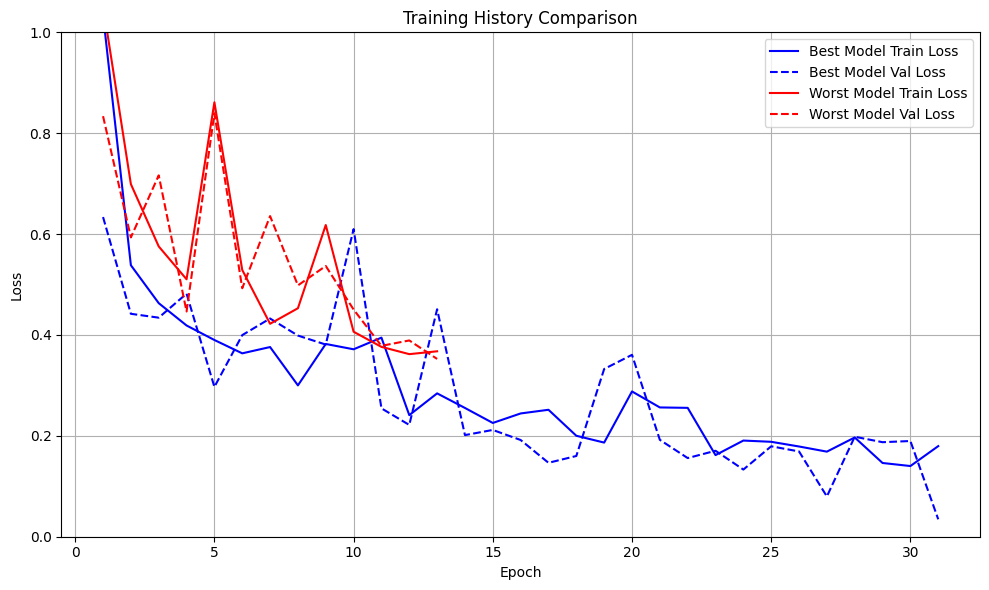

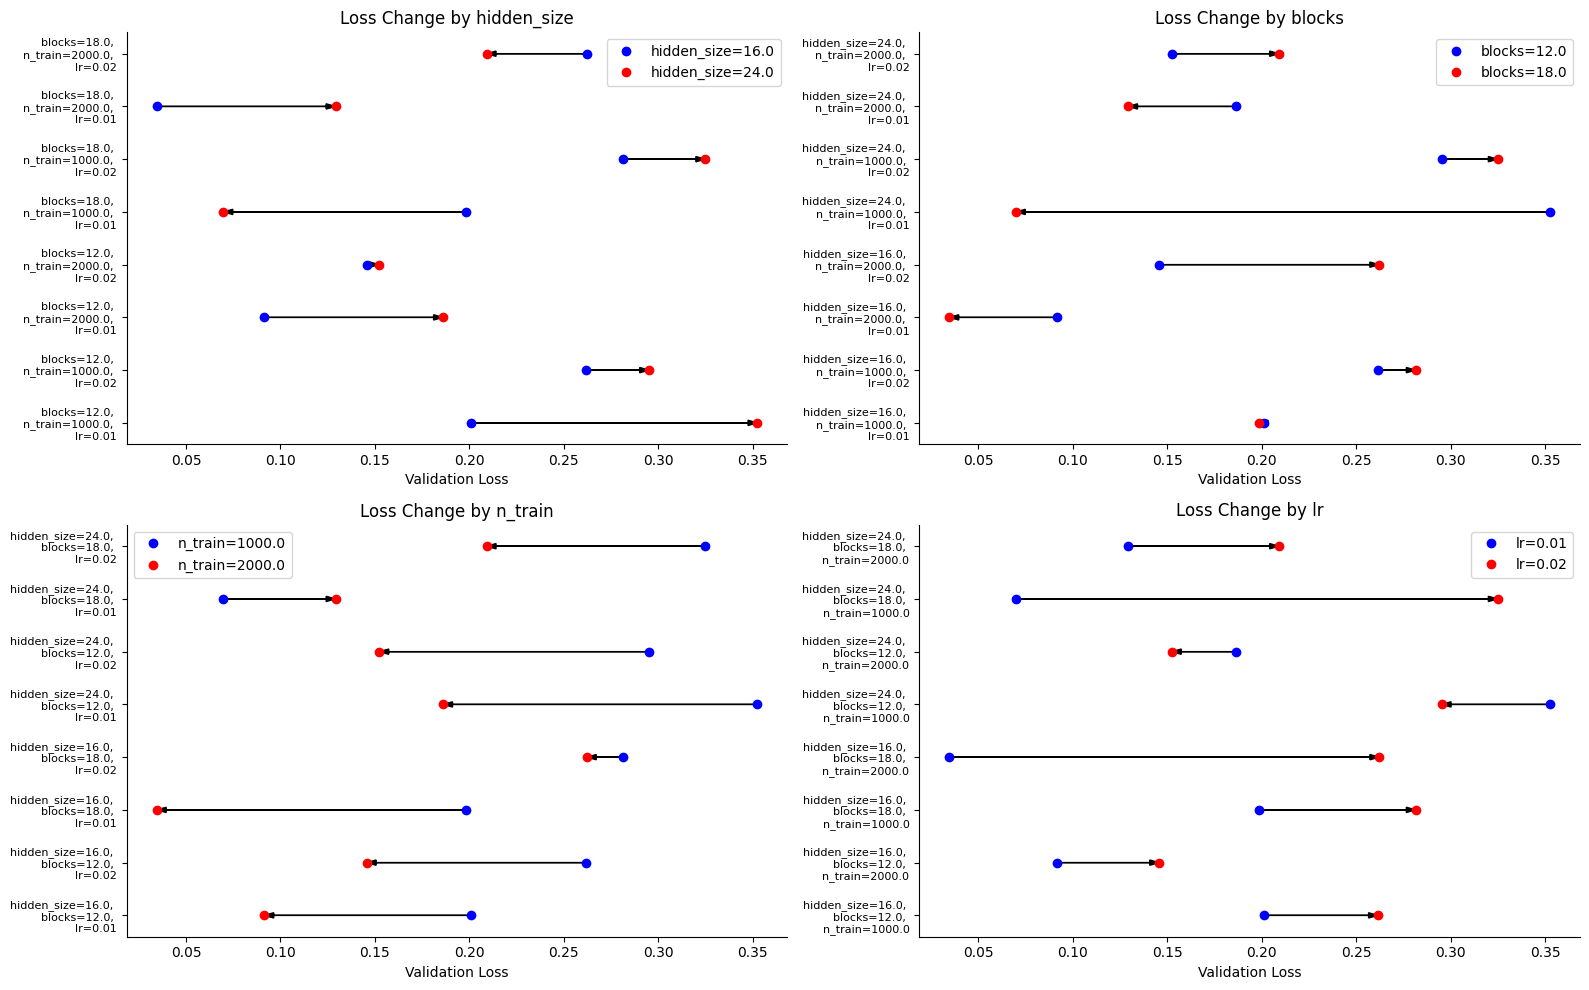

In [8]:
# Check hyperparameters
plot_training_histories(best_path, worst_path, model_names=['Best Model', 'Worst Model'])
plot_all_parameter_changes(min_losses_df)

Above, we can see that both for the best and worst model, performance increased with training. The worst model also converged much more quickly (early stoppage is implemented, so after the end of the curve, 15 further training epochs occurred in which the validation loss did not drop). This hyperparameter grid isn't the first one we arrived at, but we tried to shift things around until no hyperparameter change universally yielded an improvement (otherwise the choice of hyperparameter would be clear). Indeed, sometimes the blue dot achieves lower loss and sometimes the red one, indicating that it's not always clear which should be chosen.

All reconstructions are within 0.0001 of the original points: True


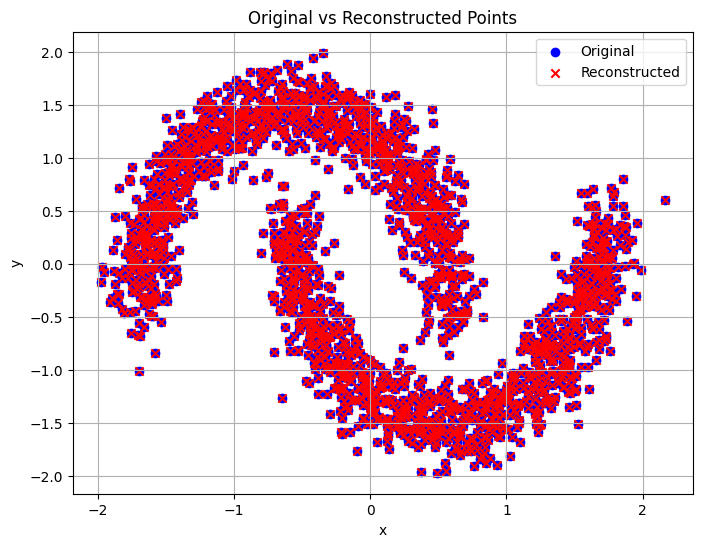

In [8]:
# Run checks
check_2d_reconstructions(x_test, x_reconstructed_test)

We can indeed see above that the normalising flow is invertible

Squared MMD between codes and true normal sample: 18571276.0


/tmp/ipykernel_43683/1670048576.py:230: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


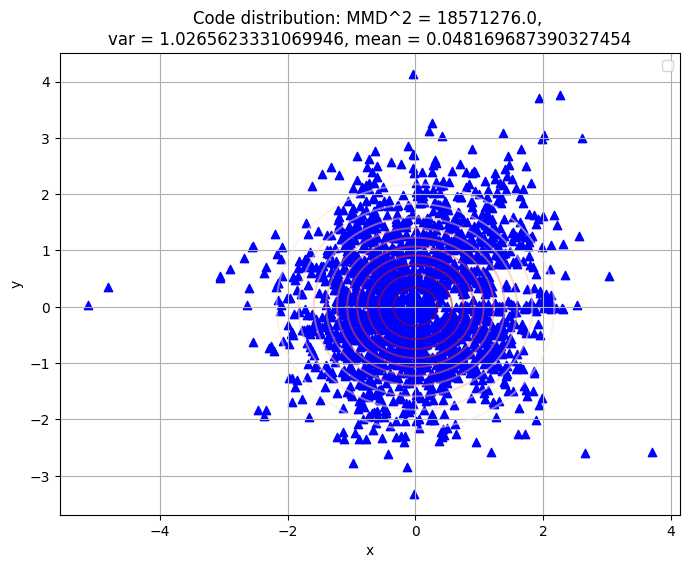

In [9]:
check_normality(z_test)

The codes also look appropriately normally distributed

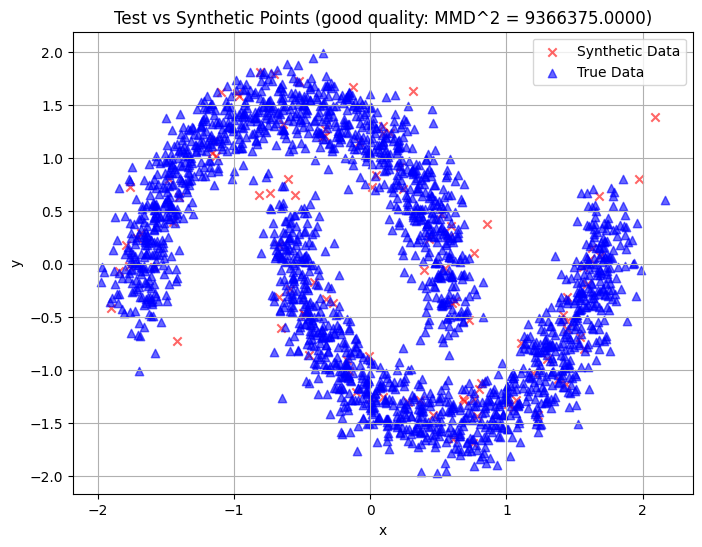

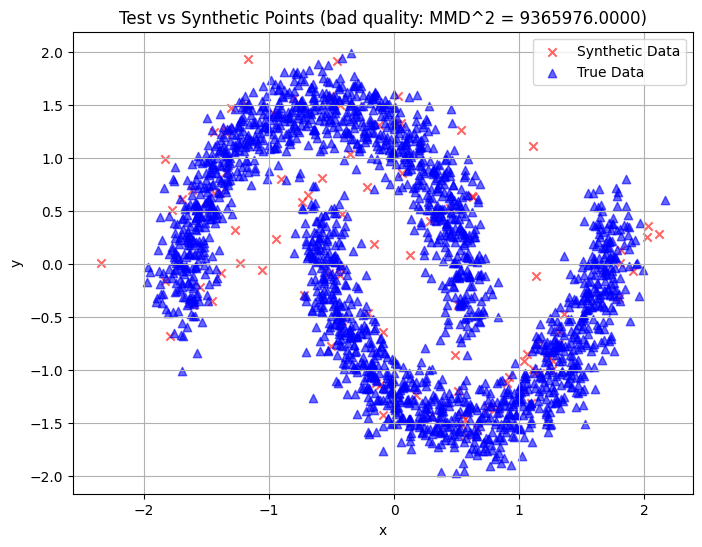

In [11]:
check_generation_quality(x_synth_good, x_test, quality = 'good')
check_generation_quality(x_synth_bad, x_test, quality = 'bad')   

It looks like both the good and the bad synthetic data fits the test data relatively well, but the bad data (with the higher MMD) is visibly a little bit further off the mark, as expected. That is to say that a lower MMD visually corresponds to better synthetic data. All in all, the normalising flow looks to have worked as expected and can create appropriate synthetic data.

## GMM Analysis


We can now do the same training and analysis for the GMMs dataset.

In [12]:
# Apply to gmm dataset
os.makedirs('ex3/models/gmms', exist_ok=True)
best_model_path='ex3/models/gmms/gmms_INN.pt'
min_losses = init_and_train_from_grid(hparams_grid, fixed_params, best_model_path, 'gmm')

# Save results
min_losses.to_csv('ex3/min_losses_gmm.csv', index=False)

Training model ex3/models/gmms/gmms_INN_ntrain1000_hiddensize16_blocks12_lr0,01.pt
EPOCH 1:
  training batch loss: 0.8468204233050346
  validation batch loss: 0.6114137287323291
EPOCH 11:
  training batch loss: 0.13306249611079693
  validation batch loss: 0.6135636659768912
EPOCH 21:
  training batch loss: 0.16507361620664596
  validation batch loss: 0.3147923963574263
EPOCH 31:
  training batch loss: 0.1466415697708726
  validation batch loss: 0.11596607904021557
Early stopping after 32 epochs
Training model ex3/models/gmms/gmms_INN_ntrain1000_hiddensize16_blocks12_lr0,02.pt
EPOCH 1:
  training batch loss: 0.9508967310190201
  validation batch loss: 0.48126890796881455
EPOCH 11:
  training batch loss: -0.12013735152781009
  validation batch loss: -0.2919320280735309
EPOCH 21:
  training batch loss: -0.27097239807248114
  validation batch loss: -0.4304158469805351
EPOCH 31:
  training batch loss: -0.4066530932486057
  validation batch loss: -0.43287770736675996
EPOCH 41:
  training bat

In [13]:
if seed:
    torch.manual_seed(seed)
    np.random.seed(seed)

n_test = 100
input_size = 2
min_losses_df = pd.read_csv('ex3/min_losses_gmm.csv')
best_path, worst_path, best_params, worst_params = find_best_model_from_tabular(min_losses_df)

# Get models
good_inn = RealNVP(input_size, int(best_params['hidden_size']), int(best_params['blocks']), device  ='cpu')
checkpoint = torch.load(best_path, weights_only=False)
good_inn.load_state_dict(checkpoint['model_state_dict'])

# Get various datasets
x_test, _ = get_standardised_gmm(int(best_params['n_train']), fixed_params.radius)
z_test = good_inn.get_codes(x_test) # Codes corresponding to test data
x_reconstructed_test = good_inn.get_reconstructions(z_test) # Reconstructions of test data
x_synth_good, _ = good_inn.sample(n_test) # good synthetic data


    hidden_size  blocks  n_train    lr  min_val_loss
0          16.0    12.0   1000.0  0.01     -0.121010
1          16.0    12.0   1000.0  0.02     -0.666320
2          16.0    12.0   2000.0  0.01     -0.818746
3          16.0    12.0   2000.0  0.02     -0.334914
4          16.0    18.0   1000.0  0.01     -0.711941
5          16.0    18.0   1000.0  0.02     -0.594080
6          16.0    18.0   2000.0  0.01     -0.802183
7          16.0    18.0   2000.0  0.02     -0.553460
8          24.0    12.0   1000.0  0.01     -0.698607
9          24.0    12.0   1000.0  0.02     -0.575494
10         24.0    12.0   2000.0  0.01     -0.556630
11         24.0    12.0   2000.0  0.02     -0.478749
12         24.0    18.0   1000.0  0.01     -0.793250
13         24.0    18.0   1000.0  0.02     -0.645429
14         24.0    18.0   2000.0  0.01     -0.692860
15         24.0    18.0   2000.0  0.02     -0.389078
       Metric      Loss  Hidden Size  Blocks  N Train  Learning Rate
0   Best Loss -0.818746       

Squared MMD between codes and true normal sample: 15756368.0


/tmp/ipykernel_76200/2399626410.py:230: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


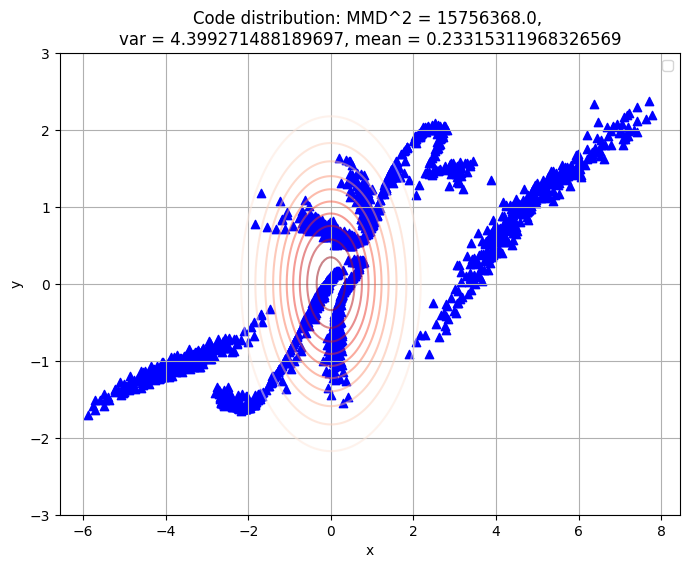

In [14]:
check_normality(z_test)

This time the codes don't look normally distributed. It looks like there may be five separate clusters, suggesting that the model is struggling due to the unconditional functions it's requested to apply. It's difficult to tell from the loss how well we should expect the codes to conform to a normal distribution, since we don't know the entropy of the system, so we don't know the theoretical minimum bound. This bodes very poorly for sampling, though, since the synthetically generated codes lie on a distribution (the standard normal) that has not great overlap with the true code distribution.

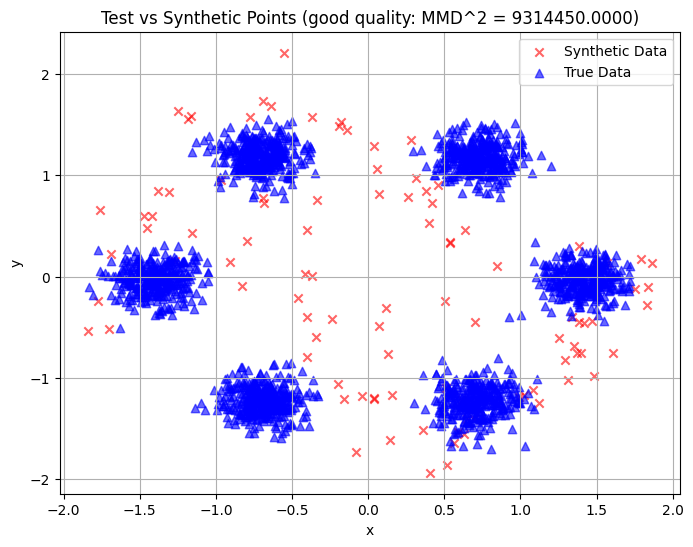

In [15]:

check_generation_quality(x_synth_good, x_test, quality = 'good')

As expected, the generated data is quite poor. The models did converge, having stopped early, so I expect that the hyperparameters are inappropriate. This makes sense since the distribution is likely more complex than the two moons dataset, so a wider and deeper distribution is likely needed.

# 2 Two moons with a conditional invertible neural network

We now repeat the training but proceed conditionally. First we train our models:

In [19]:
# Hparams
hparams_grid = Namespace()
fixed_params = Namespace()

## Architecture hparams
hparams_grid.hidden_size = [16,24] 
hparams_grid.blocks = [12,18]

## Training hparams
hparams_grid.n_train = [500]
hparams_grid.lr = [0.01, 0.02]
hparams_grid.n_epoch = 200

# Fixed params
fixed_params.input_size = 2 
fixed_params.condition_size = 1
fixed_params.conditional = True
fixed_params.batch_size = 80
fixed_params.noise = 0.1
fixed_params.seed = 11121
fixed_params.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fixed_params.positive_labels = None # For gmm dataset
fixed_params.radius = 1

# Apply to moons dataset
os.makedirs('ex3/models/moons_conditional', exist_ok=True)
best_model_path='ex3/models/moons_conditional/moons_INN.pt'
min_losses = init_and_train_from_grid(hparams_grid, fixed_params, best_model_path, 'moons')

min_losses.to_csv('ex3/min_losses_conditional_moons.csv', index=False)

# Apply to gmm dataset with all labels
os.makedirs('ex3/models/gmms_conditional', exist_ok=True)
best_model_path='ex3/models/gmms_conditional/gmms_INN.pt'
min_losses = init_and_train_from_grid(hparams_grid, fixed_params, best_model_path, 'gmm')

# Save results
min_losses.to_csv('ex3/min_losses_conditional_gmm.csv', index=False)

# Rerun with only gmm with binary labels
fixed_params.positive_labels = [0,2] # For gmm dataset]

os.makedirs('ex3/models/gmms_conditional_bin', exist_ok=True)
best_model_path='ex3/models/gmms_conditional_bin/gmms_INN.pt'
min_losses = init_and_train_from_grid(hparams_grid, fixed_params, best_model_path, 'gmm')

# Save results
min_losses.to_csv('ex3/min_losses_conditional_bin_gmm.csv', index=False)


Training model ex3/models/moons_conditional/moons_INN_ntrain500_hiddensize16_blocks12_lr0,01.pt
EPOCH 1:
  training batch loss: 0.8816442131996155
  validation batch loss: 0.4923703074455261
EPOCH 11:
  training batch loss: -0.2000442177057266
  validation batch loss: -0.18018988519906998
EPOCH 21:
  training batch loss: -0.544028127193451
  validation batch loss: -0.5319242626428604
EPOCH 31:
  training batch loss: -0.6763361811637878
  validation batch loss: -0.293722465634346
Early stopping after 38 epochs
Training model ex3/models/moons_conditional/moons_INN_ntrain500_hiddensize16_blocks12_lr0,02.pt
EPOCH 1:
  training batch loss: 1.2087217092514038
  validation batch loss: 0.39793661236763
EPOCH 11:
  training batch loss: -0.09850553274154664
  validation batch loss: -0.16942518576979637
EPOCH 21:
  training batch loss: -0.6091580390930176
  validation batch loss: -0.5887803733348846
EPOCH 31:
  training batch loss: -0.6302051305770874
  validation batch loss: -0.5920116752386093


And now we can perform analysis. We first need a few helper functions and set-up

## Two moons analysis

In [20]:
def find_best_model_conditional(min_losses_df, dataset = 'moons', conditional = False):
    print(min_losses_df)

    best_params = min_losses_df.loc[min_losses_df['min_val_loss'].idxmin()]

    # Return path of best models
    best_path = get_path_from_params(best_params['n_train'], best_params['hidden_size'], best_params['blocks'], best_params['lr'],
                                     dataset, conditional)
    

    return best_path, best_params

# Find best model
min_losses_df = pd.read_csv('ex3/min_losses_moons.csv')

best_path, best_params = find_best_model_conditional(min_losses_df, dataset = 'moons', conditional = True)

    hidden_size  blocks  n_train    lr  min_val_loss
0          16.0    12.0   1000.0  0.01      0.200984
1          16.0    12.0   1000.0  0.02      0.261488
2          16.0    12.0   2000.0  0.01      0.091458
3          16.0    12.0   2000.0  0.02      0.145654
4          16.0    18.0   1000.0  0.01      0.198246
5          16.0    18.0   1000.0  0.02      0.281467
6          16.0    18.0   2000.0  0.01      0.034539
7          16.0    18.0   2000.0  0.02      0.262160
8          24.0    12.0   1000.0  0.01      0.352491
9          24.0    12.0   1000.0  0.02      0.295135
10         24.0    12.0   2000.0  0.01      0.186077
11         24.0    12.0   2000.0  0.02      0.152333
12         24.0    18.0   1000.0  0.01      0.069792
13         24.0    18.0   1000.0  0.02      0.324886
14         24.0    18.0   2000.0  0.01      0.129181
15         24.0    18.0   2000.0  0.02      0.209113


In [21]:
if seed:
    torch.manual_seed(seed)
    np.random.seed(seed)
# Get models
input_size = 2
best_inn = RealNVP(input_size, int(best_params['hidden_size']), int(best_params['blocks']), condition_size=1, device='cpu')
checkpoint = torch.load(best_path, weights_only=False)
best_inn.load_state_dict(checkpoint['model_state_dict'])

dataset = 'moons'

# Get various datasets
best_params
if dataset == 'moons':
    x_test, labels_test = get_standardised_moons(int(best_params['n_train']), fixed_params.noise)
elif dataset == 'gmm':
    x_test, labels_test = get_standardised_gmm(int(best_params['n_train']), fixed_params.radius)
z_test = best_inn.get_codes(x_test, labels_test) # Codes corresponding to test data
x_synth_good, labels_synth = best_inn.sample(n_test, conditions = [0,1], seed = seed) # good synthetic data


Squared MMD between codes and true normal sample: 18866564.0


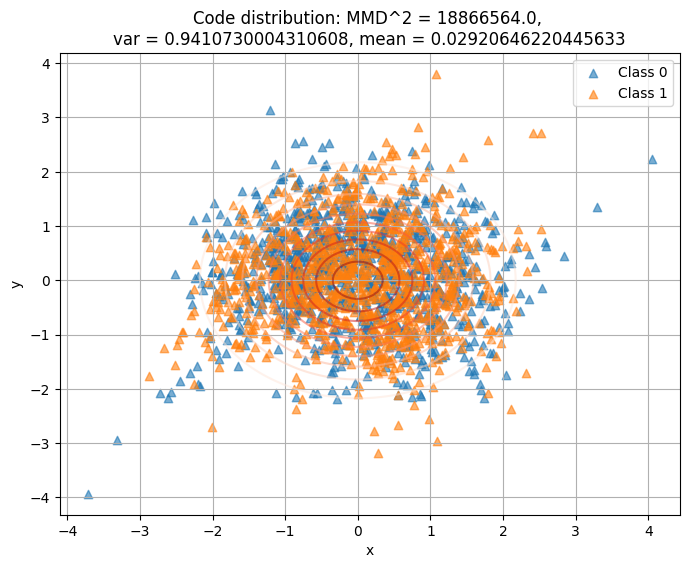

In [22]:
# Run checks
check_normality(z_test, labels_test)

The codes are once again normally distributed. It's interesting to note that there isn't any clustering of the codes based on classes in the code space; but this makes sense since we didn't enforce any dissimilarity.

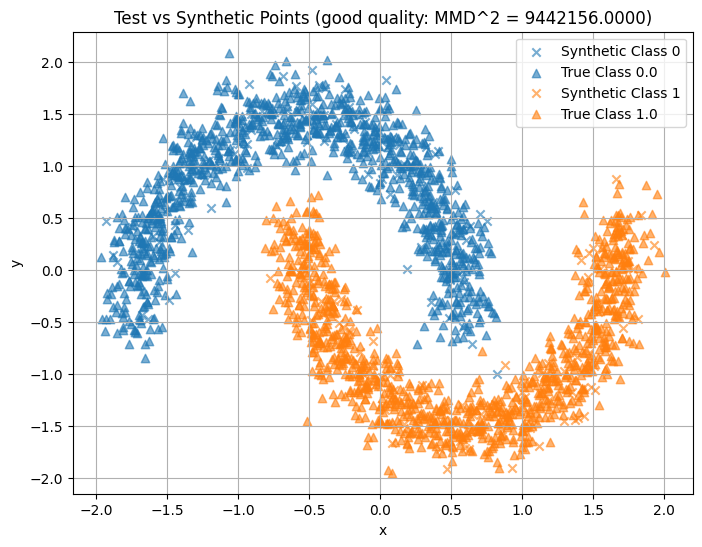

In [23]:
check_generation_quality(x_synth_good, x_test, quality = 'good', labels_synth = labels_synth, labels_test = labels_test)

We see what we hoped to see: The synthetic data of class i is close to the true data of class i for all i. This is quite a convincing result.

## GMM Analysis 

## All classes

We first consider the gmm with all classes kept, before assessing the binary case

In [38]:
min_losses_df = pd.read_csv('ex3/min_losses_conditional_gmm.csv')
best_path, best_params = find_best_model_conditional(min_losses_df, dataset = 'gmms', conditional = True)

if seed:
    torch.manual_seed(seed)
    np.random.seed(seed)
# Get models
input_size = 2
best_inn = RealNVP(input_size, int(best_params['hidden_size']), int(best_params['blocks']), condition_size=1, device='cpu')
checkpoint = torch.load(best_path, weights_only=False)
best_inn.load_state_dict(checkpoint['model_state_dict'])


# Get various datasets
best_params
x_test, labels_test = get_standardised_gmm(int(best_params['n_train']), 0.1, conditional=True)
z_test = best_inn.get_codes(x_test, labels_test) # Codes corresponding to test data
x_synth_good, labels_synth = best_inn.sample(n_test, conditions = range(6), seed = seed) # good synthetic data


   hidden_size  blocks  n_train    lr  min_val_loss
0         16.0    12.0    500.0  0.01     -2.805697
1         16.0    12.0    500.0  0.02     -3.014770
2         16.0    18.0    500.0  0.01     -2.770653
3         16.0    18.0    500.0  0.02     -2.718880
4         24.0    12.0    500.0  0.01     -2.720076
5         24.0    12.0    500.0  0.02     -2.903169
6         24.0    18.0    500.0  0.01     -2.544980
7         24.0    18.0    500.0  0.02     -2.862413


Squared MMD between codes and true normal sample: 1147997.0


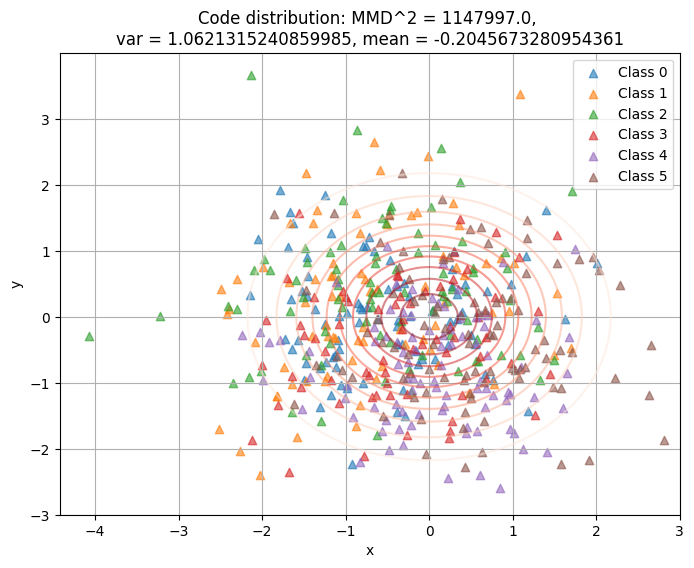

In [39]:
# Run checks
check_normality(z_test, labels_test)


The encoded test data does look to be approximately normally distributed

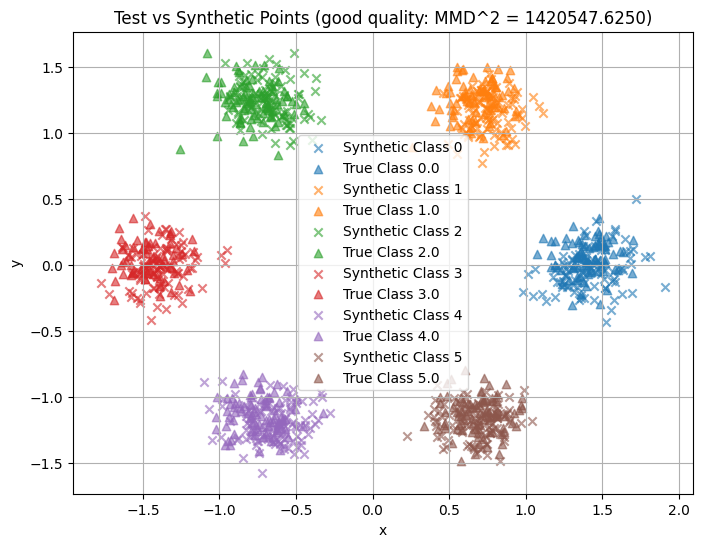

In [40]:
check_generation_quality(x_synth_good, x_test, quality = 'good', labels_synth = labels_synth, labels_test = labels_test)

This time, the model performed far better, actually managing to learn the distribution. This makes sense, since each conditional distribution is very simple (Gaussian), and so the INN has a much better ability to learn it than the more complex mixture model.

## Binary case

We proceeed to do the same with the GMM only having two labels.

In [46]:
min_losses_df = pd.read_csv('ex3/min_losses_conditional_bin_gmm.csv')
best_path, best_params = find_best_model_conditional(min_losses_df, dataset = 'gmms', conditional = True)
best_path = best_path.replace('_conditional', '_conditional_bin')

   hidden_size  blocks  n_train    lr  min_val_loss
0         16.0    12.0    500.0  0.01     -1.383623
1         16.0    12.0    500.0  0.02     -1.623433
2         16.0    18.0    500.0  0.01     -1.681918
3         16.0    18.0    500.0  0.02     -1.435163
4         24.0    12.0    500.0  0.01     -1.298345
5         24.0    12.0    500.0  0.02     -1.533466
6         24.0    18.0    500.0  0.01     -1.644774
7         24.0    18.0    500.0  0.02     -1.088335


In [55]:
if seed:
    torch.manual_seed(seed)
    np.random.seed(seed)
# Get models
input_size = 2
best_inn = RealNVP(input_size, int(best_params['hidden_size']), int(best_params['blocks']), condition_size=1, device='cpu')
checkpoint = torch.load(best_path, weights_only=False)
best_inn.load_state_dict(checkpoint['model_state_dict'])


# Get various datasets
best_params
x_test, labels_test = get_standardised_gmm(int(best_params['n_train']), 0.1, conditional=True)
labels_test = relabel_to_binary(labels_test, positive_labels=fixed_params.positive_labels)
labels_test = 1 - labels_test # Dirty fix since I implemented the labels in reverse. Would need to fix get_codes, but no time
z_test = best_inn.get_codes(x_test, labels_test) # Codes corresponding to test data
x_synth_good, labels_synth = best_inn.sample(n_test, conditions = range(2), seed = seed) # good synthetic data
labels_synth = relabel_to_binary(labels_synth, positive_labels=fixed_params.positive_labels)

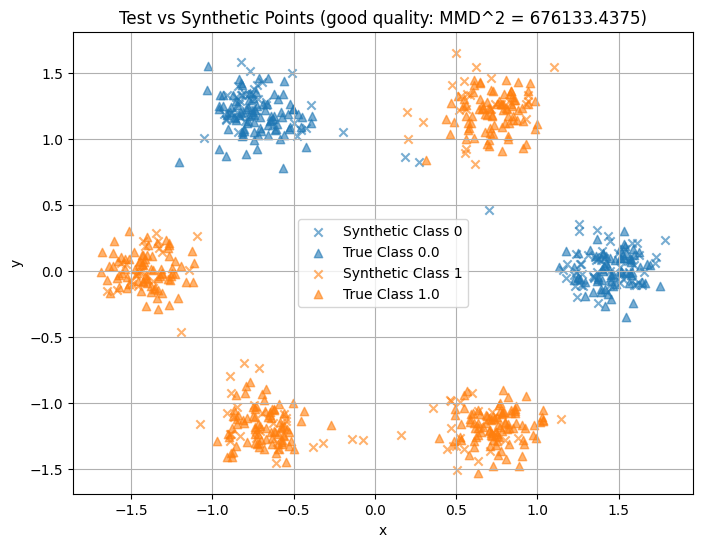

In [56]:
check_generation_quality(x_synth_good, x_test, quality = 'good', labels_synth = labels_synth, labels_test = labels_test)

This time the generation isn't quite as good: there seems to be some little bridges connecting some modes. The worse performance makes sense since the conditional distributions to be learned are once again more complex (since they're no longer gaussian). A better method would be to train with 6 classes and then restrict to two after, but one would need to have prior knowledge to know that's sensible. I take away that if we know that our model has n distinct clusters, then we should better train with n classes and then postprocess, even if n is greater than the true number of classes.

# 3 Higher-dimensional data with an INN

We train our models on the digits data, now

In [58]:
# Hparams
hparams = Namespace()
fixed_params = Namespace()

## Architecture hparams
hparams.hidden_size = 36
hparams.blocks = 24

## Training hparams
hparams.lr = 0.01
hparams.n_epoch = 200

# Fixed params
fixed_params.input_size = 64
fixed_params.batch_size = 64
fixed_params.seed = 11121
fixed_params.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fixed_params.conditional = False
fixed_params.positive_labels = None
fixed_params.condition_size = 0

results = pd.DataFrame(columns = ['k', 'min_val_loss'])
for k in [0,2,4,8,16]:
    model_path = f'ex3/models/digits/digits{k}.pt'
    os.makedirs('ex3/models/digits', exist_ok=True)
    history = init_and_train(hparams, fixed_params, model_path, 'digits', k)

    # Get minimum validation loss
    min_val_loss = min(history['val_loss'])
    
    # Add row to results DataFrame
    results.loc[len(results)] = [int(k), min_val_loss]

EPOCH 1:
  training batch loss: 1127464184787.4783
  validation batch loss: 1847577739264.0
EPOCH 11:
  training batch loss: 345755346.0869565
  validation batch loss: 340440021.3333333
EPOCH 21:
  training batch loss: 97934532.86956522
  validation batch loss: 102463028.0
EPOCH 31:
  training batch loss: 59020565.04347826
  validation batch loss: 62908009.333333336
EPOCH 41:
  training batch loss: 43358048.69565217
  validation batch loss: 45773090.666666664
EPOCH 51:
  training batch loss: 35547377.47826087
  validation batch loss: 36392275.0
EPOCH 61:
  training batch loss: 28385510.347826086
  validation batch loss: 28401770.333333332
EPOCH 71:
  training batch loss: 52886835.652173914
  validation batch loss: 51852070.0
Early stopping after 75 epochs


AttributeError: 'Tensor' object has no attribute 'copy'

In [ ]:
display(results)

We see above the training results for the different k's. We didn't perform a test split, so we're going to analyse some training codes. This won't necessarily generalise, however, to test data, but is still done to demonstrate some analysis.

## k=0

In [ ]:
inn = RealNVP(fixed_params.input_size, hparams.hidden_size, hparams.blocks, fixed_params.condition_size)
ckpt = torch.load('ex3/models/digits/digits0.pt')
inn.load_state_dict(ckpt['model_state_dict'])

# Obtain data and check normality
samples = inn.sample(500)

samples_sub_list = [samples[:, [0,1]], samples[:,[1,2]], samples[:, [0,2]]]

for digits_sub in samples_sub_list:
    check_normality(digits_sub)
    

 We can see above the code distributions for two given dimensions. 

## Varying k filling unimportant distributions with 0

In [ ]:
# Quality for increasing k.
k = 2
inn = RealNVP(fixed_params.input_size, hparams.hidden_size, hparams.blocks, fixed_params.condition_size)
ckpt = torch.load(f'ex3/models/digits/digits{k}.pt')
inn.load_state_dict(ckpt['model_state_dict'])

# Obtain data and check normality
samples = inn.sample(500, k = k, fill = 0)


